In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam



# Simulation 1 : Parameters are generated uniformly 

In [2]:
# Black-Scholes formula for European call option
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Generate synthetic Black-Scholes option prices
def generate_data(n_samples):
    S = np.random.uniform(50, 150, n_samples)  # Stock price
    K = 100  # Strike price
    T = np.random.uniform(0.02, 2, n_samples)  # Time to maturity
    r = np.random.uniform(0.01, 0.1, n_samples)  # Risk-free rate
    sigma = np.random.uniform(0.1, 0.5, n_samples)  # Volatility
    prices = black_scholes_call(S, K, T, r, sigma)
    
    data = pd.DataFrame({'S': S, 'K': K, 'T': T, 'r': r, 'sigma': sigma, 'C': prices})

    return data


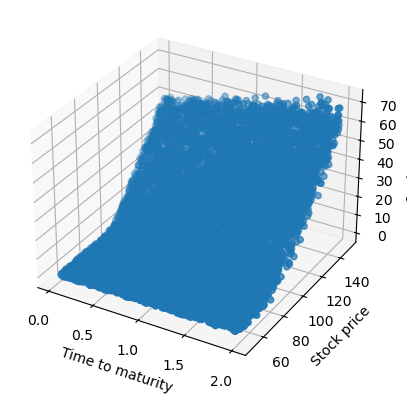

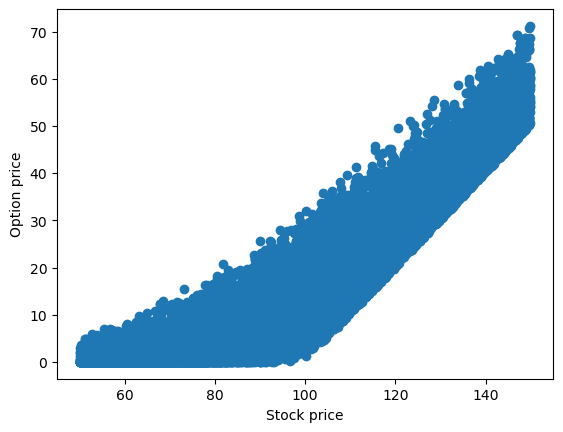

In [3]:

np.random.seed(42)

# Generate synthetic data
n_samples = 10000

data = generate_data(n_samples)

# Split data into training and test sets
X = data[['S', 'K', 'T', 'r', 'sigma']]
y = data['C']


# plot option prices in a 3D plot as a function of time to maturity and stock price
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X['T'], X['S'], y)
ax.set_xlabel('Time to maturity')
ax.set_ylabel('Stock price')
ax.set_zlabel('Option price')
plt.show()

# plot option prices in a 2D plot as a function of stock price
plt.scatter(X['S'], y)
plt.xlabel('Stock price')
plt.ylabel('Option price')
plt.show()





In [7]:
def CheckAccuracy(y_true, y_pred):
    stats = dict()
    stats['diff'] = y_true - y_pred
    stats['rmse'] = np.sqrt(np.mean(stats['diff']**2))
    print("Root Mean Squared Error:   " , stats['rmse'])
    stats['mape'] = np.mean(np.abs(stats['diff'] / y_true)) 
    print("Mean Absolute Percentage Error:   " , stats['mape'])
    stats['mse'] = np.mean(stats['diff']**2)
    print("Mean Squared Error:   " , stats['mse'])
    stats['mae'] = np.mean(np.abs(stats['diff']))
    print("Mean Absolute Error:   " , stats['mae'])
    return stats

# split data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:


# standardize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# create a neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(5,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mse')

# train the model
model.fit(X_train, y_train, epochs=50, batch_size=64)



# make predictions on the test set and rescale them
#y_pred = y_scaler.inverse_transform(model.predict(X_test_scaled)).flatten()
y_pred = model.predict(X_test).flatten()


# check accuracy
CheckAccuracy(y_test, y_pred)





Epoch 1/50
125/125 [==============================] - 1s 3ms/step - loss: 46.2460
Epoch 2/50
125/125 [==============================] - 0s 3ms/step - loss: 18.2269
Epoch 3/50
125/125 [==============================] - 0s 3ms/step - loss: 12.1732
Epoch 4/50
125/125 [==============================] - 0s 3ms/step - loss: 10.3274
Epoch 5/50
125/125 [==============================] - 0s 3ms/step - loss: 7.5366
Epoch 6/50
125/125 [==============================] - 0s 3ms/step - loss: 6.7797
Epoch 7/50
125/125 [==============================] - 0s 3ms/step - loss: 5.6553
Epoch 8/50
125/125 [==============================] - 0s 3ms/step - loss: 4.6969
Epoch 9/50
125/125 [==============================] - 0s 3ms/step - loss: 5.5409
Epoch 10/50
125/125 [==============================] - 0s 3ms/step - loss: 4.3732
Epoch 11/50
125/125 [==============================] - 0s 3ms/step - loss: 3.9225
Epoch 12/50
125/125 [==============================] - 0s 3ms/step - loss: 3.1384
Epoch 13/50
125/125 [

{'diff': 6252   -2.045115
 4684   -0.252165
 1731   -0.924767
 4742   -0.175530
 4521   -0.565973
           ...   
 6412    3.677378
 8285    1.637343
 7853   -1.294855
 1095   -0.069176
 6929    2.078881
 Name: C, Length: 2000, dtype: float64,
 'rmse': 1.2495781457043011,
 'mape': 1.4159976535383074e+39,
 'mse': 1.5614455422217999,
 'mae': 0.8828614634245844}

In [9]:

# train the neural network model where the option price is divided by the strike price and the stock price is divided by the strike price
# also the option price is divided by the strike price in the test set


X_train = X_train.copy()
X_train['M'] = X_train['S'] / X_train['K']
X_train['K'] = X_train['K'] / X_train['K']


X_test = X_test.copy()

X_test['M'] = X_test['S'] / X_test['K']
X_test['K'] = X_test['K'] / X_test['K']

y_train = y_train / X_train['K']
y_test = y_test / X_test['K']

X_train = X_train[['M','T', 'r', 'sigma']]

X_test = X_test[['M','T', 'r', 'sigma']]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()


model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(4,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mse')

model.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=64)

y_pred = scaler.inverse_transform(model.predict(X_test_scaled)).flatten()

CheckAccuracy(y_test*X_test['K'], y_pred* X_test['K'])




KeyError: 'S'